In [1]:
import pandas as pd
import pyreadstat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from econtools import read, outreg, table_statrow, write_notes
import econtools as econ
import econtools.metrics as mt
import math

In [2]:
df, meta = pyreadstat.read_sav("df.sav")
df_HH1, meta = pyreadstat.read_sav("C:/Users/thxkn/OneDrive/바탕 화면/CV/박사지원서류/WS_HJ/KEEP/KEEPData_1-12Wave_Ver12/DATA(수능, 직업력, 가중치, 패널조사현황 자료 포함)/1-12차년도 DATA(SPSS)/1차년도(2004) DATA/중학교 3학년생 코호트/by_m_household.sav")

In [3]:
df_HH1['parental_edu'] = df_HH1[['BYH26006','BYH27006']].max(axis = 1)
df_HH1 = df_HH1[df_HH1['parental_edu']>0]
df = pd.merge(df, df_HH1)
df # 1739 observations

,BYSID,BYHID,GENDER,BYSCLASS,region,schooltype,F2S01004,F2S01005,F2S01006,F2S01007,...,BYH27010C,BYH27011,BYH27012C,BYH27013,BYH27014,BYH28001,BYH28002,BYH28003,BYH28004,parental_edu
0,1003.0,10031.0,1.0,1.0,8.0,7.0,1.0,0.0,1.0,0.0,...,-5.0,-5.0,-5.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0
1,1003.0,10031.0,1.0,1.0,8.0,7.0,NaN,NaN,NaN,NaN,...,-5.0,-5.0,-5.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0
2,1005.0,10051.0,1.0,1.0,15.0,5.0,1.0,0.0,1.0,0.0,...,-5.0,-5.0,-5.0,1.0,2.0,3.0,1.0,2.0,3.0,4.0
3,1005.0,10051.0,1.0,1.0,15.0,5.0,NaN,NaN,NaN,NaN,...,-5.0,-5.0,-5.0,1.0,2.0,3.0,1.0,2.0,3.0,4.0
4,1007.0,10071.0,1.0,1.0,2.0,7.0,2.0,0.0,1.0,1.0,...,-5.0,-5.0,-5.0,1.0,2.0,3.0,1.0,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,2836.0,28361.0,0.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,...,-5.0,-5.0,-5.0,1.0,2.0,3.0,2.0,1.0,1.0,5.0
1735,2837.0,28371.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,-5.0,-5.0,-5.0,1.0,2.0,3.0,2.0,1.0,1.0,5.0
1736,2863.0,28631.0,1.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,...,-5.0,-5.0,-5.0,1.0,2.0,2.0,1.0,1.0,1.0,5.0
1737,2940.0,29401.0,0.0,1.0,8.0,0.0,NaN,NaN,NaN,NaN,...,-5.0,2.0,11123101.0,1.0,2.0,2.0,0.0,2.0,2.0,7.0


<h2>Variables</h2> 


1. Dependent variable: perfshare
2. Independent variables: income rank, p_edu, p_eff, t_eff, attainment ( 0 - 9 )
3. fe: gender, region, schooltype, year

In [4]:
# Achievement Goals
df['perf'] = df['favorablejudg']+df['negativejudg']
df['perfshare'] = df['perf'] / (df['perf'] + df['learning'])
df['learningshare'] = df['learning'] / (df['learning']+df['perf']) 

In [5]:
#현재 성적 'F3S01129', 'F2S01109'
df['attainment'] = np.nan
df.loc[df['year'] == 2004, 'attainment'] = 9 - df['F3S01129'] + 1
df.loc[df['year'] == 2003, 'attainment'] = 9 - df['F2S01109'] + 1

In [22]:
# teacher effect
# F3S01066 , F3S01067, F3S01068, F3S01069 -> 1,2 서로 바꾸기 (높을수록 좋은 선생님 되게)
# F3S01070, F3S01071, F3S01072, F3S01073 -> 매우그렇다 (높을수록 좋은 선생님)

# F2S01049, F2S01050, F2S01051, F2S01052 -> 1,2 바꾸기
# F2S01053, F2S01054, F2S01055, F2S01056 -> 매우그렇다( 높을 수록 좋음 )

df['teacher_effect'] = np.nan
df.loc[df['year'] == 2003, 'teacher_effect'] = (df.loc[df['year'] == 2003,'F2S01053'] + df.loc[df['year'] == 2003, 'F2S01054'] + df.loc[df['year'] == 2003, 'F2S01055'] + df.loc[df['year'] == 2003, 'F2S01056'])/4
df.loc[df['year'] == 2004, 'teacher_effect'] =  (df.loc[df['year'] == 2004,'F3S01070']+ df.loc[df['year'] == 2004, 'F3S01071'] + df.loc[df['year'] == 2004, 'F3S01072'] + df.loc[df['year'] == 2004, 'F3S01073'])/4

In [20]:
# Parents Effect (male)F3S02009 / (fe) F3S02031
df.loc[(df['F3S02009'] < 0) | (df['F3S02009'].isna() == True), 'F3S02009'] = 0
df.loc[(df['F3S02031'] < 0) | (df['F3S02031'].isna() == True), 'F3S02031'] = 0
df['parents_effect'] = df[['F3S02009','F3S02031']].max(axis = 1)

In [21]:
#goal list
goal_list = ['learning', 'betterperson', 'betterjob', 'futurework', 'forsociety', 'favorablejudg',  'popular',  'competition', 'forced', 'negativejudg',  'penalty']
other_goals = ['betterperson', 'betterjob', 'futurework', 'forsociety',  'popular',  'competition', 'forced',  'penalty']

exog = ['income_rank_p', 'region', 'schooltype', 'GENDER', 'year', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] + other_goals

<h2> Part 1. Mental Resource </h2>

In [141]:
goal_list = ['learning', 'betterperson', 'betterjob', 'futurework', 'forsociety', 'favorablejudg',  'popular',  'competition', 'forced', 'negativejudg',  'penalty']

df['mental_resource'] = 0
for i in goal_list:
    df['mental_resource'] = df['mental_resource']+df[i]
df['mental_resource'] = df['mental_resource']/len(goal_list)
df['mental_resource'] = df['mental_resource'].round(3)

In [142]:
df['mental_resource'].describe().round(3)

count    1739.000
mean        2.985
std         0.471
min         1.000
25%         2.727
50%         3.000
75%         3.273
max         4.455
Name: mental_resource, dtype: float64

lb:  1.9079999999999995
ub:  4.0920000000000005


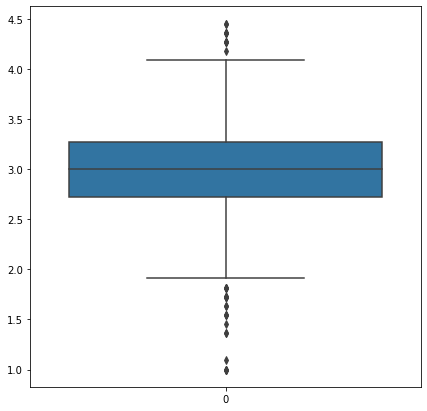

In [157]:
plt.figure(figsize=(7,7))
sns.boxplot(data = df['mental_resource'])
plt.show

def outliers(data):
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3-q1
    lower_bound = q1 - (iqr *1.5)
    print('lb: ', lower_bound)
    upper_bound = q3 + (iqr * 1.5)
    print('ub: ', upper_bound)

    return lower_bound, upper_bound, np.where((data > upper_bound)|(data < lower_bound))

lb, ub, mental_out = outliers(df['mental_resource'])

In [189]:
df2 = df.loc[(df['mental_resource']>= lb)&(df['mental_resource']<=ub)]

In [139]:
j = 1
reg_result = []
for i in goal_list:
    exog = ['income_rank_p', 'region', 'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect']
    print(mt.reg(df, i , exog, fe_name = 'year', addcons = True))
    globals()['reg_{}'.format(j)] = mt.reg(df, i , exog, fe_name = 'year', addcons = True)
    reg_result.append(globals()['reg_{}'.format(j)])
    j = j + 1

regs = tuple(reg_result)
'''
exog_tab = ['income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'pressure_mom', '_cons']
# Put coefficients and standard errors in a table
table_string = outreg(regs,
                      exog_tab,     # Add these coefficients to the table
                      ['Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect','Constant'],
                      digits=3)                           # Round to 3 decimal digits.-

# Add R^2 to the table
table_string += "\\\\ \n"                           # Empty line between betas and r2
table_string += table_statrow("R$^2$",               # Add a row with this label
                              [x.r2 for x in regs], digits=3) # Fill the row with these values
                              

# Save the table string to a file
results_path = 'mental_reg_tab.tex'
with open(results_path,'w') as f:
    f.write(table_string)

# Save separate file with table notes
#notes = "Sample size is {}.".format(reg1.N)
#write_notes(notes, results_path)

'''

Dependent variable:	learning
N:			1739
R-squared:		0.1228
Estimation method:	OLS
VCE method:		Standard (Homosk.)
Fixed effects by:	year
  No. of FE:		  2
                coeff    se      t   p>t CI_low CI_high
income_rank_p   0.080 0.110  0.723 0.470 -0.137   0.296
region          0.004 0.004  0.995 0.320 -0.004   0.012
schooltype      0.009 0.007  1.303 0.193 -0.005   0.023
GENDER         -0.280 0.038 -7.347 0.000 -0.355  -0.205
parental_edu    0.036 0.018  2.002 0.045  0.001   0.071
attainment      0.106 0.011  9.771 0.000  0.085   0.127
teacher_effect  0.169 0.023  7.228 0.000  0.123   0.215
parents_effect  0.056 0.022  2.598 0.009  0.014   0.098

Dependent variable:	betterperson
N:			1739
R-squared:		0.0676
Estimation method:	OLS
VCE method:		Standard (Homosk.)
Fixed effects by:	year
  No. of FE:		  2
                coeff    se      t   p>t CI_low CI_high
income_rank_p   0.170 0.109  1.552 0.121 -0.045   0.384
region          0.003 0.004  0.687 0.492 -0.005   0.011
schooltype     

'\nexog_tab = [\'income_rank_p\', \'parental_edu\', \'attainment\', \'teacher_effect\', \'pressure_mom\', \'_cons\']\n# Put coefficients and standard errors in a table\ntable_string = outreg(regs,\n                      exog_tab,     # Add these coefficients to the table\n                      [\'Parental Income\',                 # Use these label for the coeffs\n                       \'Parents Education\' ,\n                       \'Academic Ability\',\n                       \'Teacher Effect\',\n                       \'Parents Effect\',\'Constant\'],\n                      digits=3)                           # Round to 3 decimal digits.-\n\n# Add R^2 to the table\ntable_string += "\\\\ \n"                           # Empty line between betas and r2\ntable_string += table_statrow("R$^2$",               # Add a row with this label\n                              [x.r2 for x in regs], digits=3) # Fill the row with these values\n                              \n\n# Save the table string

<h2> Part 2. Parental Income and Perfshare </h2>

1. whole sample
2. delete mental resource outliers

In [187]:
# different perfshare proxy #

#1. competition
df['perfshare_c'] = (df['perf'] + df['competition']) / (df['perf']+ df['competition'] + df['learning'])

np.var(df['learning'])
var_l = np.var(df['learning'])
var_neg = np.var(df['negativejudg'])
var_fav = np.var(df['favorablejudg'])
var_com = np.var(df['competition'])

#2. var
df['perfshare_var'] = (var_neg*df['negativejudg'] + var_fav*df['favorablejudg']) / (var_neg*df['negativejudg'] + var_fav*df['favorablejudg']+var_l*df['learning'])

#3. competition var
df['perfshare_c_var'] = (var_com*df['competition'] + var_neg*df['negativejudg'] + var_fav*df['favorablejudg']) / (var_com*df['competition'] + var_neg*df['negativejudg'] + var_fav*df['favorablejudg']+var_l*df['learning'])

In [197]:
# iv candidate: region
exog = ['schooltype', 'GENDER', 'year', 'attainment', 'teacher_effect','parental_edu','parents_effect'] #+ other_goals

# 1. baseline
print(mt.ivreg(df, 'perfshare', 'income_rank_p','region', exog, addcons = True))
reg1 = mt.ivreg(df, 'perfshare', 'income_rank_p','region', exog)

# 2. comp
print(mt.ivreg(df, 'perfshare_c', 'income_rank_p','region', exog))
reg2 = mt.ivreg(df, 'perfshare_c', 'income_rank_p','region', exog)

# 3. variance weights
print(mt.ivreg(df, 'perfshare_var', 'income_rank_p','region', exog))
reg3 = mt.ivreg(df, 'perfshare_var', 'income_rank_p','region', exog)

# 4. comp var weights
print(mt.ivreg(df, 'perfshare_c_var', 'income_rank_p','region', exog))
reg4 = mt.ivreg(df, 'perfshare_c_var', 'income_rank_p','region', exog)

regs = (reg1,reg2,reg3,reg4)

exog_tab = ['income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect']
# Put coefficients and standard errors in a table
table_string = outreg(regs,
                      exog_tab,     # Add these coefficients to the table
                      ['Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3)                           # Round to 3 decimal digits.-

# Add R^2 to the table
#table_string += "\\\\ \n"                           # Empty line between betas and r2
#table_string += table_statrow("R$^2$",               # Add a row with this label
#                              [x.r2 for x in regs], digits=3) # Fill the row with these values
                              

# Save the table string to a file
results_path = 'main_ivreg.tex'
with open(results_path,'w') as f:
    f.write(table_string)

# Save separate file with table notes
#notes = "Sample size is {}.".format(reg1.N)
#write_notes(notes, results_path)

Dependent variable:	perfshare
N:			1739
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff     se      t   p>t CI_low CI_high
income_rank_p  -0.230  0.163 -1.407 0.160 -0.550   0.090
schooltype      0.001  0.002  0.736 0.462 -0.002   0.004
GENDER          0.005  0.005  0.998 0.318 -0.005   0.015
year           -0.027  0.012 -2.196 0.028 -0.051  -0.003
attainment     -0.006  0.001 -4.237 0.000 -0.009  -0.003
teacher_effect -0.010  0.003 -3.099 0.002 -0.016  -0.004
parental_edu    0.013  0.011  1.176 0.240 -0.009   0.035
parents_effect  0.009  0.003  3.178 0.002  0.004   0.015
_cons          54.422 24.453  2.226 0.026  6.461 102.383

Dependent variable:	perfshare_c
N:			1739
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se      t   p>t CI_low CI_high
income_rank_p  -0.165 0.134 -1.229 0.219 -0.428   0.098
schooltype     -0.000 0.001 -0.286 0.775 -0.003   0.002
GENDER          0.005 0.004  1.081 

In [ ]:
df2 = df.loc[(df['mental_resource']>= lb)&(df['mental_resource']<=ub)]

In [195]:
# sample2
# iv candidate: region
exog = ['schooltype', 'GENDER', 'year', 'attainment', 'teacher_effect','parental_edu','parents_effect'] #+ other_goals

# 1. baseline
print(mt.ivreg(df2, 'perfshare', 'income_rank_p','region', exog))
reg1 = mt.ivreg(df2, 'perfshare', 'income_rank_p','region', exog)

# 2. comp
print(mt.ivreg(df2, 'perfshare_c', 'income_rank_p','region', exog))
reg2 = mt.ivreg(df2, 'perfshare_c', 'income_rank_p','region', exog)

# 3. variance weights
print(mt.ivreg(df2, 'perfshare_var', 'income_rank_p','region', exog))
reg3 = mt.ivreg(df2, 'perfshare_var', 'income_rank_p','region', exog)

# 4. comp var weights
print(mt.ivreg(df2, 'perfshare_c_var', 'income_rank_p','region', exog))
reg4 = mt.ivreg(df2, 'perfshare_c_var', 'income_rank_p','region', exog)

regs = (reg1,reg2,reg3,reg4)
exog_tab = ['income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect', '_cons']
# Put coefficients and standard errors in a table
table_string = outreg(regs,
                      exog_tab,     # Add these coefficients to the table
                      ['Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect','Constant'],
                      digits=3)                           # Round to 3 decimal digits.-

# Add R^2 to the table
#table_string += "\\\\ \n"                           # Empty line between betas and r2
#table_string += table_statrow("R$^2$",               # Add a row with this label
#                              [x.r2 for x in regs], digits=3) # Fill the row with these values
                              

# Save the table string to a file
results_path = 'main_ivreg_2.tex'
with open(results_path,'w') as f:
    f.write(table_string)

# Save separate file with table notes
#notes = "Sample size is {}.".format(reg1.N)
#write_notes(notes, results_path)

Dependent variable:	perfshare
N:			1704
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se      t   p>t CI_low CI_high
income_rank_p  -0.237 0.169 -1.399 0.162 -0.569   0.095
schooltype      0.000 0.002  0.162 0.871 -0.003   0.003
GENDER          0.006 0.005  1.191 0.234 -0.004   0.016
year            0.000 0.000 42.389 0.000  0.000   0.000
attainment     -0.007 0.002 -4.191 0.000 -0.010  -0.003
teacher_effect -0.009 0.003 -2.877 0.004 -0.015  -0.003
parental_edu    0.014 0.011  1.181 0.238 -0.009   0.036
parents_effect  0.004 0.002  1.770 0.077 -0.000   0.009

Dependent variable:	perfshare_c
N:			1704
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se      t   p>t CI_low CI_high
income_rank_p  -0.170 0.138 -1.232 0.218 -0.441   0.101
schooltype     -0.000 0.001 -0.339 0.734 -0.003   0.002
GENDER          0.005 0.004  1.086 0.278 -0.004   0.013
year            0.000 0.000 57.358 0.000  0.0

<h2> Part 3. Self-Assessment </h2>

In [24]:
df_sat = pd.read_excel("C:/Users/thxkn/OneDrive/바탕 화면/CV/박사지원서류/WS_HJ/KEEP/KEEPData_1-12Wave_Ver12/DATA(수능, 직업력, 가중치, 패널조사현황 자료 포함)/수능(2005-2009학년도) DATA(Layout 포함)/수능 DATA(2008-2009학년도)_중학교 3학년생 코호트.xlsx")

In [25]:
df_sat = df_sat[["AT08_32","AT08_33","AT08_34","AT09_32","AT09_33","AT09_34","BYSID"]]
df_sat["total_score_1"] = df_sat["AT08_32"] + df_sat["AT08_33"] + df_sat["AT08_34"]
df_sat["total_score_2"] = df_sat["AT09_32"] + df_sat["AT09_33"] + df_sat["AT09_34"]

In [201]:
# 과목 잘한다 (1 전혀 그렇지 않다 - 5 매우 그렇다)
df_b = pd.merge(df, df_sat)

df_b = df_b[df_b['F3S01100']>0]
df_b = df_b[df_b['F3S01103']>0]
df_b = df_b[df_b['F3S01106']>0]

df_b = df_b.rename(columns = {'F3S01100': 'korean_b', 'F3S01103': 'math_b', 'F3S01106':'eng_b'})
df_b = df_b.rename(columns = {"AT08_32": 'korean_sat',"AT08_33": 'math_sat',"AT08_34": 'eng_sat'})

#delete missing variables
df_b = df_b[df_b['korean_sat']>0]
df_b = df_b[df_b['math_sat']>0]
df_b = df_b[df_b['eng_sat']>0]

In [202]:
# rescale beliefs: 
beliefs = ['korean_b','math_b','eng_b']
sat = ['korean_sat', 'math_sat', 'eng_sat']

subjects = ['korean', 'math', 'eng']

for b in beliefs:
    df_b[b] = (5-df_b[b]) + 1

In [203]:
# rescale sat:

for s in sat:
    df_b.loc[df_b[s] == 1, s ] = 1
    df_b.loc[(df_b[s] == 2 ) | (df_b[s] ==3), s ] = 2
    df_b.loc[(df_b[s] == 6) | (df_b[s] == 4) | (df_b[s] == 5), s ] = 3
    df_b.loc[ (df_b[s] == 7) | (df_b[s] == 8) , s ] = 4
    df_b.loc[df_b[s] == 9, s ] = 5


for s in subjects:
    df_b[s+'_b_gap'] = df_b[s+'_b'] - df_b[s+'_sat']
    #print(len(df_b[df_b[s+'_b_gap']<0])) # underestimate themselves

for s in subjects:
    df_b[s+'_b_gap_abs'] = abs(df_b[s+'_b_gap'])

In [204]:
for s in subjects:
    df_b.loc[(df_b[s+'_b']) == 0 | (df_b[s + '_sat'] == 0), s+ '_b_gap' ] = np.nan

for s in subjects:
    print(df_b[s+'_b_gap'].describe())

count    875.000000
mean      -0.114286
std        0.961841
min       -3.000000
25%       -1.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: korean_b_gap, dtype: float64
count    875.000000
mean       0.334857
std        1.050709
min       -4.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: math_b_gap, dtype: float64
count    875.000000
mean       0.019429
std        0.951134
min       -3.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        2.000000
Name: eng_b_gap, dtype: float64


In [216]:
######## assessment subjects #########
#goal list
goal_list = ['learning', 'betterperson', 'betterjob', 'futurework', 'forsociety', 'favorablejudg',  'popular',  'competition', 'forced', 'negativejudg',  'penalty']
other_goals = ['betterperson', 'betterjob', 'futurework', 'forsociety',  'popular',  'competition', 'forced',  'penalty']

exog = ['perfshare','income_rank_p', 'region', 'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals

i = 1
for s in subjects:
    globals()['reg{}'.format(i)] = mt.reg(df_b, s+'_b_gap', exog, addcons = True)
    print(globals()['reg{}'.format(i)])
    i = i+1

regs = (reg1,reg2,reg3)

exog_tab = ['perfshare','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect', '_cons']
# Put coefficients and standard errors in a table
table_string = outreg(regs,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented','Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect','Constant'],
                      digits=3)                           # Round to 3 decimal digits.-

# Add R^2 to the table
table_string += "\\\\ \n"                           # Empty line between betas and r2
table_string += table_statrow("R$^2$",               # Add a row with this label
                              [x.r2 for x in regs] , digits=3) # Fill the row with these values
                              

# Save the table string to a file
results_path = 'selfassessment_sub.tex'
with open(results_path,'w') as f:
    f.write(table_string)

Dependent variable:	korean_b_gap
N:			875
R-squared:		0.0528
Estimation method:	OLS
VCE method:		Standard (Homosk.)
                coeff    se      t   p>t CI_low CI_high
perfshare       0.801 0.335  2.389 0.017  0.143   1.460
income_rank_p   0.353 0.186  1.900 0.058 -0.012   0.717
region          0.005 0.007  0.706 0.480 -0.009   0.019
schooltype      0.048 0.015  3.135 0.002  0.018   0.079
GENDER         -0.113 0.066 -1.725 0.085 -0.242   0.016
parental_edu    0.047 0.030  1.603 0.109 -0.011   0.106
attainment      0.087 0.021  4.089 0.000  0.045   0.129
teacher_effect -0.011 0.040 -0.264 0.792 -0.089   0.068
parents_effect -0.010 0.032 -0.326 0.744 -0.074   0.053
_cons          -1.815 0.357 -5.087 0.000 -2.515  -1.115

Dependent variable:	math_b_gap
N:			875
R-squared:		0.0443
Estimation method:	OLS
VCE method:		Standard (Homosk.)
                coeff    se      t   p>t CI_low CI_high
perfshare      -0.074 0.368 -0.200 0.842 -0.796   0.649
income_rank_p   0.039 0.204  0.189 0.850 

In [206]:
#goal list
goal_list = ['learning', 'betterperson', 'betterjob', 'futurework', 'forsociety', 'favorablejudg',  'popular',  'competition', 'forced', 'negativejudg',  'penalty']
other_goals = ['betterperson', 'betterjob', 'futurework', 'forsociety',  'popular',  'competition', 'forced',  'penalty']

exog = ['income_rank_p',  'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals

for s in subjects:
    print(mt.ivreg(df_b, s+'_b_gap', 'perfshare', 'region', exog, addcons = True))

Dependent variable:	korean_b_gap
N:			875
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff     se      t   p>t  CI_low CI_high
perfshare       7.746 12.014  0.645 0.519 -15.834  31.326
income_rank_p   0.414  0.263  1.574 0.116  -0.102   0.931
schooltype      0.055  0.021  2.564 0.011   0.013   0.097
GENDER         -0.106  0.083 -1.272 0.204  -0.268   0.057
parental_edu    0.063  0.047  1.348 0.178  -0.029   0.155
attainment      0.149  0.109  1.359 0.175  -0.066   0.364
teacher_effect  0.048  0.111  0.427 0.669  -0.171   0.266
parents_effect -0.088  0.140 -0.629 0.530  -0.363   0.187
_cons          -6.718  8.571 -0.784 0.433 -23.540  10.104

Dependent variable:	math_b_gap
N:			875
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff     se      t   p>t  CI_low CI_high
perfshare       7.888 13.382  0.589 0.556 -18.377  34.153
income_rank_p   0.109  0.293  0.372 0.710  -0.466   0.684
schooltype      0.0

In [207]:
df_b['total_score_1']

1       17.0
3       19.0
5       15.0
7       13.0
9       21.0
        ... 
1055    26.0
1056    20.0
1058    20.0
1060    23.0
1061    11.0
Name: total_score_1, Length: 875, dtype: float64

In [208]:
df_b['total_b'] = 0
for s in subjects:
    df_b['total_b'] = df_b['total_b'] + df_b[s+'_b']

df_b['total_b'] = df_b['total_b'] / 3

s = 'total_score_1_re'
df_b[s] = df_b['total_score_1']/3
df_b.loc[df_b[s] < 1.5, s ] = 1
df_b.loc[(df_b[s] >1.5 ) & (df_b[s] <= 3), s ] = 2
df_b.loc[(df_b[s] > 3) & (df_b[s] <= 5), s ] = 3
df_b.loc[ (df_b[s] > 5)| (df_b[s] <= 7) , s ] = 4
df_b.loc[df_b[s] > 9, s ] = 5

In [209]:
df_b['total_b_gap'] = df_b['total_b'] - df_b['total_score_1_re']
df_b.loc[(df_b['total_b'] == 0) | df_b['total_score_1_re'] ==0 , 'total_b_gap'] = np.nan

In [210]:
#goal list
goal_list = ['learning', 'betterperson', 'betterjob', 'futurework', 'forsociety', 'favorablejudg',  'popular',  'competition', 'forced', 'negativejudg',  'penalty']
other_goals = ['betterperson', 'betterjob', 'futurework', 'forsociety',  'popular',  'competition', 'forced',  'penalty']

exog = ['perfshare','income_rank_p', 'region', 'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] # + other_goals

regs = mt.reg(df_b, 'total_b_gap', exog, addcons = True)
print(mt.reg(df_b, 'total_b_gap', exog, addcons = True))

#regs = tuple(regs)
exog_tab = ['income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect', '_cons']
# Put coefficients and standard errors in a table
table_string = outreg(regs,
                      exog_tab,     # Add these coefficients to the table
                      ['Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect','Constant'],
                      digits=3)                           # Round to 3 decimal digits.-

# Add R^2 to the table
table_string += "\\\\ \n"                           # Empty line between betas and r2
#table_string += table_statrow("R$^2$",               # Add a row with this label
#                              regs.r2 , digits=3) # Fill the row with these values
                              

# Save the table string to a file
results_path = 'selfassessment.tex'
with open(results_path,'w') as f:
    f.write(table_string)

#income_rank_p < 0 = self efficacy 가 높아진다

Dependent variable:	total_b_gap
N:			875
R-squared:		0.2933
Estimation method:	OLS
VCE method:		Standard (Homosk.)
                coeff    se       t   p>t CI_low CI_high
perfshare       0.336 0.188   1.783 0.075 -0.034   0.705
income_rank_p  -0.007 0.104  -0.068 0.946 -0.212   0.198
region          0.006 0.004   1.611 0.108 -0.001   0.014
schooltype     -0.026 0.009  -3.028 0.003 -0.043  -0.009
GENDER          0.027 0.037   0.726 0.468 -0.046   0.099
parental_edu   -0.064 0.017  -3.866 0.000 -0.097  -0.032
attainment     -0.193 0.012 -16.141 0.000 -0.216  -0.169
teacher_effect -0.058 0.023  -2.588 0.010 -0.102  -0.014
parents_effect -0.045 0.018  -2.488 0.013 -0.080  -0.009
_cons           0.957 0.200   4.780 0.000  0.564   1.350



In [219]:
df2_b = pd.merge(df2, df_b)

In [230]:
#sample 1.
exog = ['income_rank_p', 'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] # + other_goals

reg1 = mt.ivreg(df_b, 'total_b_gap', 'perfshare','region', exog )
print(reg1)

# Put coefficients and standard errors in a table

exog_tab = ['perfshare','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string = outreg(reg1,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 
                       'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.-
table_string += "\\\\ \n" 

#reg2
reg2 = mt.ivreg(df_b, 'total_b_gap', 'perfshare_c','region', exog )
print(reg2)
exog_tab = ['perfshare_c','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string2 = outreg(reg2,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented','Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.-
table_string2 += "\\\\ \n" 

#reg3
reg3 = mt.ivreg(df_b, 'total_b_gap', 'perfshare_var','region', exog )
exog_tab = ['perfshare_var','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string3 = outreg(reg3,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.
table_string3 += "\\\\ \n" 

#reg4
reg4 = mt.ivreg(df_b, 'total_b_gap', 'perfshare_c_var','region', exog )
exog_tab = ['perfshare_c_var','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string4 = outreg(reg4,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.
table_string4 += "\\\\ \n"                 

# Save the table string to a file
results_path = 'selfassessment.tex'
with open(results_path,'w') as f:
    f.write(table_string)
    f.write(table_string2)
    f.write(table_string3)
    f.write(table_string4)

#income_rank_p < 0 = self efficacy 가 높아진다



Dependent variable:	total_b_gap
N:			875
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se       t   p>t CI_low CI_high
perfshare       2.682 0.769   3.489 0.001  1.173   4.190
income_rank_p  -0.023 0.113  -0.202 0.840 -0.245   0.200
schooltype     -0.040 0.016  -2.565 0.010 -0.071  -0.009
GENDER          0.017 0.040   0.434 0.664 -0.061   0.096
parental_edu   -0.092 0.029  -3.125 0.002 -0.149  -0.034
attainment     -0.194 0.017 -11.584 0.000 -0.227  -0.161
teacher_effect -0.084 0.039  -2.168 0.030 -0.160  -0.008
parents_effect -0.096 0.035  -2.739 0.006 -0.165  -0.027

Dependent variable:	total_b_gap
N:			875
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se       t   p>t CI_low CI_high
perfshare_c     2.598 0.724   3.588 0.000  1.177   4.019
income_rank_p  -0.026 0.110  -0.235 0.814 -0.243   0.191
schooltype     -0.044 0.016  -2.731 0.006 -0.076  -0.012
GENDER          0.016 0.039   0.

In [226]:
#sample 2.
#sample 1.
exog = ['income_rank_p', 'schooltype', 'GENDER', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] # + other_goals

reg1 = mt.ivreg(df2_b, 'total_b_gap', 'perfshare','region', exog )
print(reg1)

# Put coefficients and standard errors in a table

exog_tab = ['perfshare','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string = outreg(reg1,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 
                       'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.-
table_string += "\\\\ \n" 

#reg2
reg2 = mt.ivreg(df2_b, 'total_b_gap', 'perfshare_c','region', exog )
print(reg2)
exog_tab = ['perfshare_c','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string2 = outreg(reg2,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented','Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.-
table_string2 += "\\\\ \n" 

#reg3
reg3 = mt.ivreg(df2_b, 'total_b_gap', 'perfshare_var','region', exog )
exog_tab = ['perfshare_var','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string3 = outreg(reg3,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.
table_string3 += "\\\\ \n" 

#reg4
reg4 = mt.ivreg(df2_b, 'total_b_gap', 'perfshare_c_var','region', exog )
exog_tab = ['perfshare_c_var','income_rank_p', 'parental_edu', 'attainment', 'teacher_effect', 'parents_effect'] #+ other_goals
table_string4 = outreg(reg4,
                      exog_tab,     # Add these coefficients to the table
                      ['Performance Oriented', 'Parental Income',                 # Use these label for the coeffs
                       'Parents Education' ,
                       'Academic Ability',
                       'Teacher Effect',
                       'Parents Effect'],
                      digits=3) # Round to 3 decimal digits.
table_string4 += "\\\\ \n"                 

# Save the table string to a file
results_path = 'selfassessment2.tex'
with open(results_path,'w') as f:
    f.write(table_string)
    f.write(table_string2)
    f.write(table_string3)
    f.write(table_string4)

#income_rank_p < 0 = self efficacy 가 높아진다



Dependent variable:	total_b_gap
N:			860
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se       t   p>t CI_low CI_high
perfshare       2.657 0.798   3.331 0.001  1.091   4.223
income_rank_p  -0.020 0.113  -0.174 0.862 -0.242   0.203
schooltype     -0.040 0.016  -2.547 0.011 -0.071  -0.009
GENDER          0.012 0.040   0.308 0.758 -0.066   0.091
parental_edu   -0.092 0.030  -3.087 0.002 -0.151  -0.034
attainment     -0.192 0.017 -11.207 0.000 -0.226  -0.159
teacher_effect -0.087 0.040  -2.140 0.033 -0.166  -0.007
parents_effect -0.091 0.037  -2.449 0.015 -0.164  -0.018

Dependent variable:	total_b_gap
N:			860
R-squared:		nan
Estimation method:	2SLS
VCE method:		Standard (Homosk.)
                coeff    se       t   p>t CI_low CI_high
perfshare_c     2.588 0.756   3.421 0.001  1.103   4.073
income_rank_p  -0.024 0.110  -0.218 0.827 -0.241   0.193
schooltype     -0.044 0.016  -2.706 0.007 -0.076  -0.012
GENDER          0.011 0.039   0.